# Libraries and Parse Data
Note: All computations were ran with last game weight hyperparameter `[0.4, 0.3, 0.2, 0.1]`

In [184]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tabulate

UNNORMALIZE_FACTOR = 131  # MAX(HomeSpreadActual) - MIN(HomeSpreadActual)
UNNORMALIZE_FACTOR_PREDICT = 41

# REGRESSION
# Return X = testable features, Y = point spread
def spread_df_rgn(normalize=False, get_custom_date_range=False, substituted_spreads=None):
  data_df = pd.read_csv('combined_out.csv')

  real_cols = data_df.select_dtypes(include=['number']).columns

  if not get_custom_date_range:
    data_df = data_df.dropna(axis=0)

  if normalize:
    for col in real_cols:
      min_val = data_df[col].min()
      max_val = data_df[col].max()
      data_df[col] = (data_df[col] - min_val) / (max_val - min_val)

  if get_custom_date_range:
    data_df = data_df[(data_df['Date'] >= '2024-04-01') & (data_df['Date'] <= '2024-04-07')]
    data_df['HomeSpread'] = substituted_spreads
    data_df['HomeSpreadCorrectDirection'] = data_df['HomeSpreadActual'] > data_df['HomeSpread']
    data_df['HomeSpreadCorrectDirection'] = data_df['HomeSpreadCorrectDirection'].astype(int)
  
  data_df = data_df.drop('AwayTeam', axis=1)\
                   .drop('HomeTeam', axis=1)\
                   .drop('Date', axis=1)
  
  data_np = data_df.to_numpy()
  data_np = data_np[:, 5:]

  data_np = data_np.astype(float)

  return data_np[:, 1:-1], data_np[:, :1]

# CLASSIFICATION
# Return X = testable features, Y = correct point spread direction
def spread_df_cls(normalize=False, get_custom_date_range=False, substituted_spreads=None):
  data_df = pd.read_csv('combined_out.csv')

  real_cols = data_df.select_dtypes(include=['number']).columns

  if not get_custom_date_range:
    data_df = data_df.dropna(axis=0)

  if normalize:
    for col in real_cols:
      min_val = data_df[col].min()
      max_val = data_df[col].max()
      data_df[col] = (data_df[col] - min_val) / (max_val - min_val)

  if get_custom_date_range:
    data_df = data_df[(data_df['Date'] >= '2024-04-01') & (data_df['Date'] <= '2024-04-07')]
    data_df['HomeSpread'] = substituted_spreads
    data_df['HomeSpreadCorrectDirection'] = data_df['HomeSpreadActual'] > data_df['HomeSpread']
    data_df['HomeSpreadCorrectDirection'] = data_df['HomeSpreadCorrectDirection'].astype(int)

  data_df = data_df.drop('AwayTeam', axis=1)\
                   .drop('HomeTeam', axis=1)\
                   .drop('Date', axis=1)
  
  data_np = data_df.to_numpy()
  data_np = data_np[:, 5:]

  data_np = data_np.astype(float)

  return data_np[:, 1:-1], data_np[:, -1:]

# K-Neighbors Regressor
We are trying to calculate the true point differential of an NBA game.

## No Normalization and No Weighting

In [185]:
X, y = spread_df_rgn()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

i_idx = list(range(2, 11))
mae_list_a = [None, None]  # don't plot k=0,1

for i in range(2, 11):
  knn = KNeighborsRegressor(n_neighbors=i).fit(X_train, y_train)
  acc_train = knn.score(X_train, y_train)
  acc_test = knn.score(X_test, y_test)

  mae_train = mean_absolute_error(knn.predict(X_train), y_train)
  mae_test = mean_absolute_error(knn.predict(X_test), y_test)

  mae_list_a.append(mae_test)

## Normalization without Weighting

In [186]:
X, y = spread_df_rgn(normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

i_idx = list(range(2, 11))
mae_list_b = [None, None]  # don't plot k=0,1

for i in range(2, 11):
  knn = KNeighborsRegressor(n_neighbors=i).fit(X_train, y_train)
  acc_train = knn.score(X_train, y_train)
  acc_test = knn.score(X_test, y_test)

  mae_train = mean_absolute_error(knn.predict(X_train), y_train)
  mae_test = mean_absolute_error(knn.predict(X_test), y_test)

  mae_list_b.append(mae_test * UNNORMALIZE_FACTOR)

## Normalization and Weighting

In [187]:
X, y = spread_df_rgn(normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

i_idx = list(range(2, 11))
mae_list_c = [None, None]  # don't plot k=0,1

for i in range(2, 11):
  knn = KNeighborsRegressor(n_neighbors=i, weights='distance').fit(X_train, y_train)
  acc_train = knn.score(X_train, y_train)
  acc_test = knn.score(X_test, y_test)

  mae_train = mean_absolute_error(knn.predict(X_train), y_train)
  mae_test = mean_absolute_error(knn.predict(X_test), y_test)

  mae_list_c.append(mae_test * UNNORMALIZE_FACTOR)

  k    No Norm/No Weight    Norm/No Weight    Norm/Weight
---  -------------------  ----------------  -------------
  2             11.7211            12.0699        12.1269
  3             10.9455            11.349         11.3671
  4             10.5709            10.9057        11.023
  5             10.3309            10.6605        10.7914
  6             10.1835            10.4632        10.6732
  7             10.0604            10.334         10.5299
  8              9.97668           10.2471        10.4204
  9              9.92128           10.2048        10.3872
 10              9.84074           10.1743        10.3249


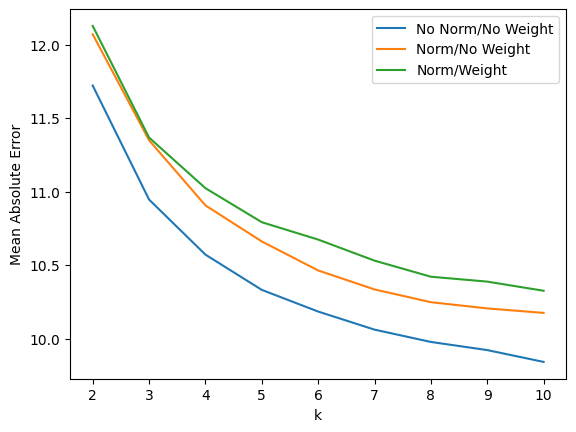

In [188]:
print(tabulate.tabulate([(x, y, z, a) for x, y, z, a in zip(i_idx, mae_list_a[2:], mae_list_b[2:], mae_list_c[2:])], headers=['k', 'No Norm/No Weight', 'Norm/No Weight', 'Norm/Weight']))

plt.plot(mae_list_a)
plt.plot(mae_list_b)
plt.plot(mae_list_c)
plt.xlabel('k')
plt.ylabel('Mean Absolute Error')

plt.legend(['No Norm/No Weight', 'Norm/No Weight', 'Norm/Weight'])

As k increases, MAE decreases, and in the best models can plateau a little under 10 (after adjusting for normalization). This means that the correct point differential is missed by about 10 points on average (showing that there is a lot of variability in NBA games that are difficult to explain statistically.)

# K-Neighbors Classifier
We are trying to estimate the point differential and compare it against the spread.

## Without Normalization

In [189]:
X, y = spread_df_cls()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

i_idx = list(range(2, 11))
acc_train_list_a = [None, None]  # don't plot k=0,1
acc_test_list_a = [None, None]   # don't plot k=0,1

for i in range(2, 11):
  knn = KNeighborsClassifier(n_neighbors=i).fit(X_train, np.ravel(y_train))
  acc_train = knn.score(X_train, y_train)
  acc_test = knn.score(X_test, y_test)

  acc_train_list_a.append(acc_train)
  acc_test_list_a.append(acc_test)

## With Normalization

In [190]:
X, y = spread_df_cls(normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

i_idx = list(range(2, 11))
acc_train_list_b = [None, None]  # don't plot k=0,1
acc_test_list_b = [None, None]   # don't plot k=0,1

for i in range(2, 11):
  knn = KNeighborsClassifier(n_neighbors=i).fit(X_train, np.ravel(y_train))
  acc_train = knn.score(X_train, y_train)
  acc_test = knn.score(X_test, y_test)

  acc_train_list_b.append(acc_train)
  acc_test_list_b.append(acc_test)

  k    Non-weighted Test    Non-weighted Train    Weighted Test    Weighted Train
---  -------------------  --------------------  ---------------  ----------------
  2             0.50732               0.74869          0.498738          0.757968
  3             0.502776              0.751089         0.508834          0.756327
  4             0.509844              0.688167         0.497224          0.692016
  5             0.499243              0.685831         0.504796          0.690186
  6             0.500505              0.656863         0.496971          0.66267
  7             0.494195              0.657116         0.493942          0.661975
  8             0.511358              0.637362         0.497981          0.641338
  9             0.504038              0.640454         0.4947            0.643042
 10             0.509086              0.622783         0.490409          0.627706


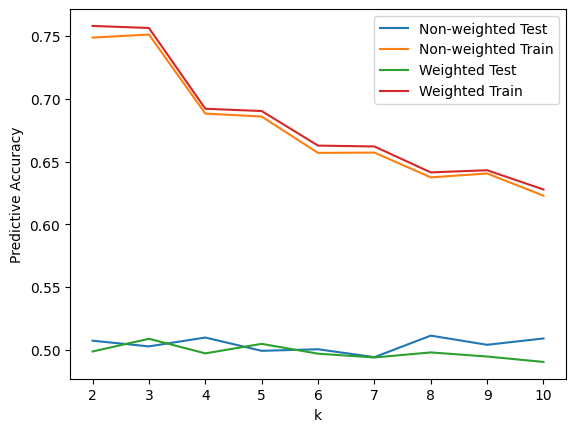

In [191]:
print(tabulate.tabulate([(x, y, z, a, b) for x, y, z, a, b in zip(i_idx, acc_test_list_a[2:], acc_train_list_a[2:], acc_test_list_b[2:], acc_train_list_b[2:])], headers=
                          ['k', 'Non-weighted Test', 'Non-weighted Train', 'Weighted Test', 'Weighted Train']
                        ))

plt.plot(acc_test_list_a)
plt.plot(acc_train_list_a)
plt.plot(acc_test_list_b)
plt.plot(acc_train_list_b)
plt.xlabel('k')
plt.ylabel('Predictive Accuracy')

plt.legend(['Non-weighted Test', 'Non-weighted Train', 'Weighted Test', 'Weighted Train'])

# Testing Novel Data
Testing all NBA games between April 1 and April 7, 2024.

In [192]:
new_point_spreads = [
  -18.5,
  -2.5,
  -12.5,
  -17.5,
  -1.5,
  -0.5,
  -15.5,
  -2.5,
  -7.5,
  9.5,
  -2.5,
  -2.5,
  -0.5,
  12.5,
  13.5,
  -4.5,
  -17.5,
  -12.5,
  -6.5,
  -12.5,
  -12.5,
  12.5,
  -1.5,
  6.5,
  -2.5,
  -3.5,
  3.5,
  3.5,
  -11.5,
  -14.5,
  -12.5,
  -4.5,
  1.5,
  -11.5,
  1.5,
  3.5,
  12.5,
  1.5,
  -2.5,
  -9.5,
  -6.5,
  -4.5,
  -10.5,
  15.5,
  -10.5,
  2.5,
  -12.5,
  10.5,
  3.5,
  -4.5,
  7.5,
  -4.5,
  -6.5,
  -16.5,
  -4.5,
  -9.5,
  -5.5,
  -2.5
]

accs = 0

for i in range(100):
  X, y = spread_df_cls(normalize=False)
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
  knn = KNeighborsClassifier(n_neighbors=8).fit(X_train, np.ravel(y_train))

  X2, y2 = spread_df_cls(normalize=False, get_custom_date_range=True, substituted_spreads=new_point_spreads)
  acc = knn.score(X2, y2)
  accs += acc

print(f"Overall acc with k=8: {accs/100}")

Overall acc with k=8: 0.4694827586206898


For a selection of recent games, the model was able to get on average 47% accurate. Interestingly enough, the non-weighted model performed better than the weighted model, with weighted being able to get as high as 52% accuracy. Weighted model struggled and got 49%.